In [90]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [196]:
df = pd.read_csv('nacas.csv')
df.head(n=20)

,naca,reynolds,alpha,CL,CD,CDp,CM,Top_Xtr,Bot_Xtr
0,0006,100000,-10.00,-0.5661,0.11269,0.10814,0.0140,1.0,0.0914
1,0006,100000,-9.75,-0.5830,0.10909,0.10461,0.0097,1.0,0.0925
2,0006,100000,-9.50,-0.7037,0.11447,0.10977,0.0241,1.0,0.0814
3,0006,100000,-9.25,-0.6934,0.11087,0.10614,0.0257,1.0,0.0859
4,0006,100000,-9.00,-0.6952,0.10675,0.10207,0.0227,1.0,0.0898
5,0006,100000,-8.75,-0.7078,0.10227,0.09768,0.0146,1.0,0.0921
6,0006,100000,-8.50,-0.7208,0.09688,0.09233,0.0047,1.0,0.0927
7,0006,100000,-8.25,-0.6967,0.09341,0.08887,0.0159,1.0,0.0987
8,0006,100000,-8.00,-0.6997,0.08881,0.08432,0.0114,1.0,0.1029
9,0006,100000,-7.75,-0.7174,0.08268,0.07796,-0.0036,1.0,0.1066


In [202]:
# Vrillage de test : pour un rayon de 5cm va de pi/2 (90°) à 0 (0°)

def f_1(x):
    return (x-0.01)/(0.09-0.01) * 1 + (x-0.09)/(0.01-0.09) * 20

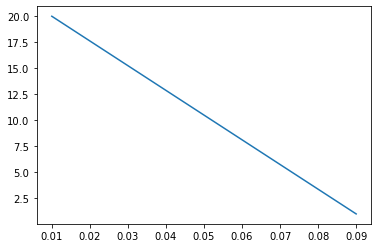

In [204]:
X = np.arange(1/100,10/100,1/100)
plt.plot(X,f_1(X))

In [186]:
def NN(element, L):
    l = len(L)
    cand = 0
    tol = np.abs(L[0])+np.abs(element)
    for k in range(l):
        if np.abs(L[k]-element)<tol:
            cand = k
            tol = np.abs(L[k]-element)
    return cand

In [96]:
sub_df = df.loc[(df['naca'] == '0006') & (df['reynolds'] == 100000)]
len(sub_df['alpha'])

77

In [97]:
NN(0.3, sub_df['alpha'])

41

In [98]:
sub_df['alpha'][30:45]

30   -2.50
31   -2.25
32   -2.00
33   -1.75
34   -1.50
35   -1.25
36   -1.00
37   -0.75
38   -0.50
39   -0.25
40    0.00
41    0.25
42    0.50
43    0.75
44    1.00
Name: alpha, dtype: float64

In [194]:
def drag_lift(naca, rayon_min, rayon_max, f_vrillage, tpm, v_vertical, largeur, pas = 5):
    pho_air = 1.2
    lift_tot = 0
    drag_tot = 0
    mu_air = 1.56*10**-5
    RAYONS = np.arange(rayon_min, rayon_max, (rayon_max-rayon_min)/pas)
    for rayon in RAYONS:
        vitesse_rot = 2 * np.pi * tpm * rayon
        rey = np.sqrt(v_vertical**2+vitesse_rot**2)*(rayon_max-rayon_min)/mu_air
        all_rey = df.loc[df['naca'] == naca]['reynolds']
        reynolds = all_rey[NN(rey, list(all_rey))]
        vrillage = f_vrillage(rayon)
        alpha = vrillage - np.arctan(v_vertical/vitesse_rot)/np.pi*180
        sub_df = df.loc[(df['naca'] == naca) & (df['reynolds'] == reynolds)]
        index = NN(alpha, list(sub_df['alpha']))
        CD = list(sub_df['CD'])[index]
        CL = list(sub_df['CL'])[index]
        lift_tot+= 1/2 * pho_air * (v_vertical**2+vitesse_rot**2) * largeur * (RAYONS[1]-RAYONS[2]) * CL
        drag_tot+= 1/2 * pho_air * (v_vertical**2+vitesse_rot**2) * largeur * (RAYONS[1]-RAYONS[2]) * CD
    return lift_tot, drag_tot


In [195]:
a,b = drag_lift(naca = '0006', rayon_min = 2/1000, rayon_max = 7/100, f_vrillage = f_1, tpm = 2200, v_vertical = 0, largeur = 1.5/100, pas = 20)

In [191]:
a

14.30161684650961

In [134]:
index = NN(a,b)

In [42]:
 x = drag_lift(1,0,10,0,0,0)